# **Book Review Recommendation system**

**Problem Statement:** Using Machine Learning build a recommendation system for books.

**Methodology:** Cosine Similarity based on Genre, Summary and Avg Rating of book

**Input:** Books and Review Tables in PostgreSQL

**Output:** Book recommendation matrix wherein a new book if given calculates the similarity and gives similar books as recommendation

*****************************************************************************************************************************

Import all required libraries

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sqlalchemy import create_engine
from gensim.downloader import load
from gensim.models import KeyedVectors

Connection to PostgreSQL databse

In [297]:
'''
Note: If getting connection error due to timeout or something like below  :
psql: error: connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
        Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
        Is the server running on that host and accepting TCP/IP connections?

Then to resolve, try below for Windows:
1. Press WIN + R 
2. Open services type - services.msc
3. Find postgres - double click on it
4. Open properties box, then click on start
'''

# Database connection

DATABASE_URL = "postgresql+psycopg2://<username>:<password>@<host>/<database_name>"
engine = create_engine(DATABASE_URL)


Load the data from Database into Dataframes

In [298]:
# Load data into DataFrames
booksdb_df = pd.read_sql_table('books', engine)
reviewsdb_df = pd.read_sql_table('review', engine)

booksdb_df

,id,title,author,genre,year_published,summary
0,24277,"Under the Greenwood Tree or, The Mellstock quire",Thomas Hardy,fiction,NaN,No description available.
1,24083,Pride and Prejudice,Jane Austen,fiction,NaN,Austen’s most celebrated novel tells the story...
2,24278,Kidnapped,Robert Louis Stevenson,fiction,NaN,An abridged version of the story complete with...
3,24365,Cat Among the Pigeons,Agatha Christie,mystery,1959.0,Unpleasant things are going on in an exclusive...
4,25011,Pictures from Italy,Charles Dickens,biography,NaN,A travelogue by Charles Dickens based on a tri...
...,...,...,...,...,...,...
995,25077,Eminent Victorians,Giles Lytton Strachey,biography,1910.0,Eminent Victorians is a groundbreaking work of...
996,25078,Something About the Author,Gale Group,biography,1972.0,Series covers individuals ranging from establi...
997,25079,La Nuit,Elie Wiesel,biography,1955.0,No description available.
998,25080,Travels with a donkey in the Cevennes,Robert Louis Stevenson,biography,NaN,On 23 September 1878 Stevenson set out from Le...


In [299]:
reviewsdb_df

,id,book_id,user_id,review_text,rating
0,1813,24277,1,Thomas Hardy's third novel in 1872 ( in fact a...,3
1,1814,24277,1,This is Hardy’s second novel and the first to ...,4
2,1815,24277,1,Thomas Hardy's second novel (first of the Wess...,3
3,1816,24277,1,Thank you Duane!!!!Sweet love story....Great a...,4
4,1817,24277,1,Hardy’s third novel is about a string band tha...,4
...,...,...,...,...,...
24767,26580,25081,1,reviews left on the individual works of each s...,5
24768,26581,25081,1,I’ve left individual reviews on every story an...,4
24769,26582,25081,1,"Holy crap, it’s a brick of brilliance! This do...",5
24770,26583,25081,1,Who can’t appreciate the style and substance o...,4


In [300]:
# Load books data
books_df = pd.read_sql_query("SELECT * FROM books", engine)

# Load reviews data
reviews_df = pd.read_sql_query("SELECT book_id, AVG(CAST(rating AS NUMERIC)) AS avg_rating FROM review GROUP BY book_id;", engine)

In [301]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   title           1000 non-null   object 
 2   author          1000 non-null   object 
 3   genre           1000 non-null   object 
 4   year_published  482 non-null    float64
 5   summary         1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


In [302]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   book_id     893 non-null    int64  
 1   avg_rating  893 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 14.1 KB


## Exploratory Data Analysis

In [303]:
# Explore the data
booksdb_df.head()

,id,title,author,genre,year_published,summary
0,24277,"Under the Greenwood Tree or, The Mellstock quire",Thomas Hardy,fiction,NaN,No description available.
1,24083,Pride and Prejudice,Jane Austen,fiction,NaN,Austen’s most celebrated novel tells the story...
2,24278,Kidnapped,Robert Louis Stevenson,fiction,NaN,An abridged version of the story complete with...
3,24365,Cat Among the Pigeons,Agatha Christie,mystery,1959.0,Unpleasant things are going on in an exclusive...
4,25011,Pictures from Italy,Charles Dickens,biography,NaN,A travelogue by Charles Dickens based on a tri...


In [304]:
booksdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   title           1000 non-null   object 
 2   author          1000 non-null   object 
 3   genre           1000 non-null   object 
 4   year_published  482 non-null    float64
 5   summary         1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


In [305]:
reviewsdb_df.head()

,id,book_id,user_id,review_text,rating
0,1813,24277,1,Thomas Hardy's third novel in 1872 ( in fact a...,3
1,1814,24277,1,This is Hardy’s second novel and the first to ...,4
2,1815,24277,1,Thomas Hardy's second novel (first of the Wess...,3
3,1816,24277,1,Thank you Duane!!!!Sweet love story....Great a...,4
4,1817,24277,1,Hardy’s third novel is about a string band tha...,4


In [306]:
reviewsdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24772 entries, 0 to 24771
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           24772 non-null  int64 
 1   book_id      24772 non-null  int64 
 2   user_id      24772 non-null  int64 
 3   review_text  24772 non-null  object
 4   rating       24772 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 967.8+ KB


Describe doesn't show any descrepancy in data as all values seems to be valid 

In [307]:
booksdb_df.describe()

,id,year_published
count,1000.000000,482.000000
mean,24582.500000,1950.844398
std,288.819436,35.015391
min,24083.000000,1900.000000
25%,24332.750000,1920.000000
50%,24582.500000,1946.000000
75%,24832.250000,1984.750000
max,25082.000000,2023.000000


In [308]:
reviewsdb_df.describe()

,id,book_id,user_id,rating
count,24772.00000,24772.000000,24772.0,24772.000000
mean,14198.50000,24558.607420,1.0,3.944453
std,7151.20477,295.292331,0.0,1.071682
min,1813.00000,24083.000000,1.0,1.000000
25%,8005.75000,24296.000000,1.0,3.000000
50%,14198.50000,24534.000000,1.0,4.000000
75%,20391.25000,24814.000000,1.0,5.000000
max,26584.00000,25082.000000,1.0,5.000000


Find Null Values in dataframe

In [309]:
booksdb_df.isnull().sum()

id                  0
title               0
author              0
genre               0
year_published    518
summary             0
dtype: int64

In [310]:
reviewsdb_df.isnull().sum()

id             0
book_id        0
user_id        0
review_text    0
rating         0
dtype: int64

With increase in Publication year the count of books in inventory seems to decreasing with least in recent years

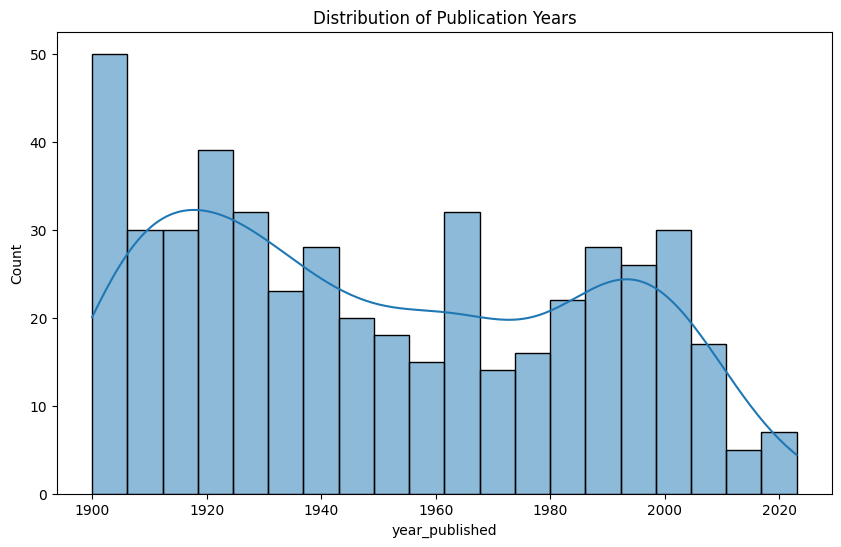

In [311]:
# Distribution of publication years
plt.figure(figsize=(10, 6))
sns.histplot(booksdb_df['year_published'], bins=20, kde=True)
plt.title('Distribution of Publication Years')
plt.show()

1. Median Rating for all of the genres is 4 and there are no outliers
2. Avg Rating over the year also shows it revolves around 4 only with some fluctuations with min at around 1975 and max in year 2020

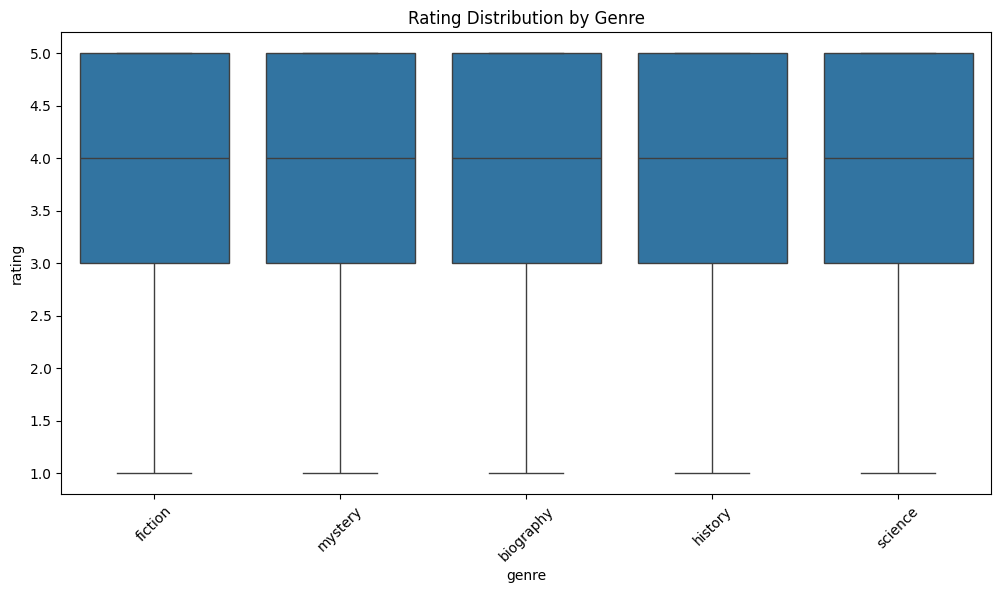

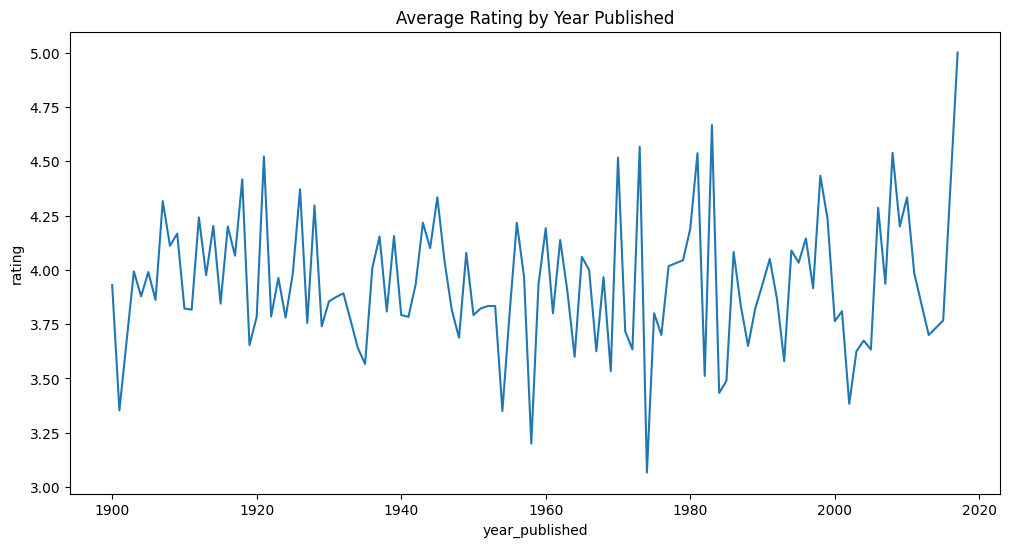

In [312]:
# Merge books and reviews data
merged_df = pd.merge(booksdb_df, reviewsdb_df, left_on='id', right_on='book_id')

# Rating vs. Genre
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='genre', y='rating')
plt.title('Rating Distribution by Genre')
plt.xticks(rotation=45)
plt.show()

# Average rating by year
average_rating_by_year = merged_df.groupby('year_published')['rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_rating_by_year, x='year_published', y='rating')
plt.title('Average Rating by Year Published')
plt.show()

As the total count of ratings increase the rating value seems to move higher reaching to about 4 or 5

Most of the books lie in range of avg rating of 3.5 to 5

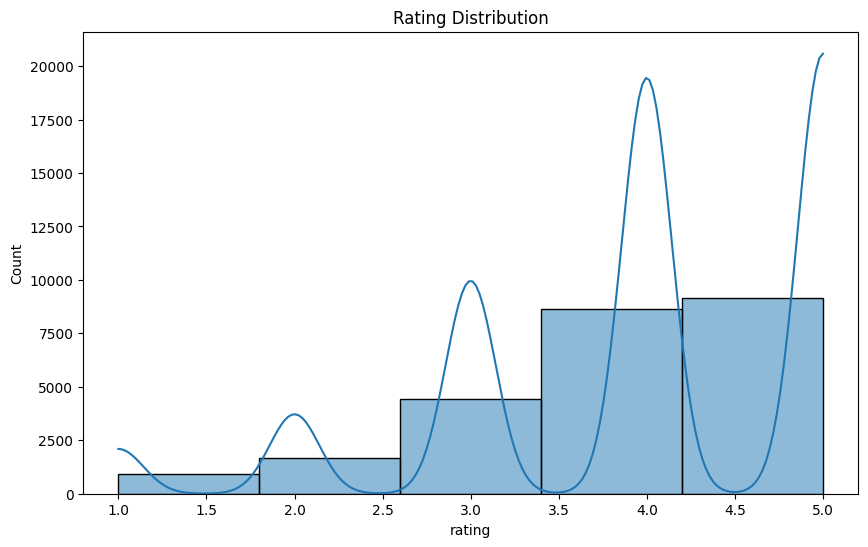

In [313]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(reviewsdb_df['rating'], bins=5, kde=True)
plt.title('Rating Distribution')
plt.show()

Books in genre of Biography and Science have the highest average rating as compared to other genres

While Mystery books seem to perform worst in terms of Avg Rating

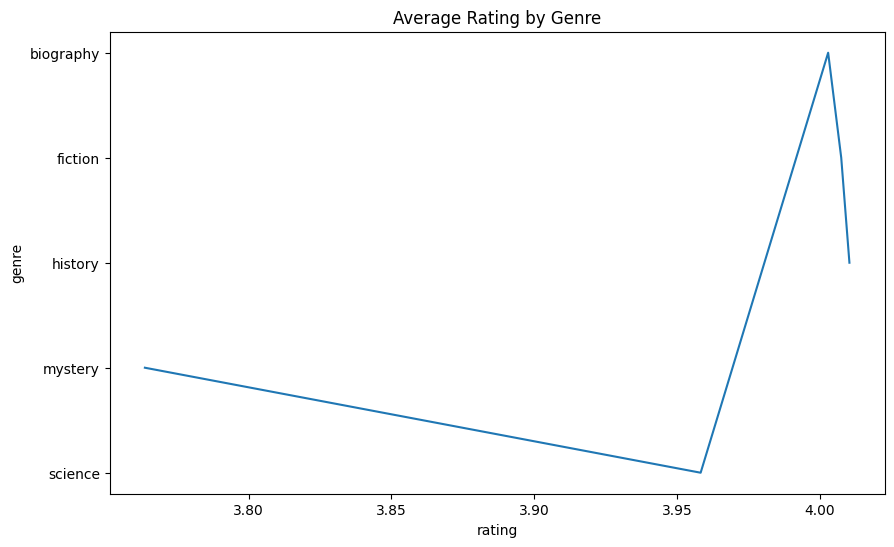

In [314]:
# Average rating by genre
avg_rating_genre = reviewsdb_df.merge(booksdb_df, right_on='id', left_on='book_id').groupby('genre')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='rating', y='genre', data=avg_rating_genre)
plt.title('Average Rating by Genre')
plt.show()

## Handling Missing Values

We had ealier seen in EDA that "Year" column is the only one which has some null values in it.

In [315]:
books_df[books_df['year_published'].isnull()]['author'].value_counts()

author
William Shakespeare            42
Charles Dickens                24
Mark Twain                     15
Wilkie Collins                 14
James Fenimore Cooper          10
                               ..
Edmund Husserl, F. Kersten      1
Grant Allen, Andrea Gouveia     1
Friedrich Engels                1
John Tyndall                    1
Diodorus Siculus                1
Name: count, Length: 241, dtype: int64

In [316]:
books_df[books_df['year_published'].isnull()]['genre'].value_counts()

genre
history      157
fiction      145
biography    132
science       53
mystery       31
Name: count, dtype: int64

In [317]:
# 1. Calculate the median year for each combination of genre and author
median_years = books_df.groupby(['genre', 'author'])['year_published'].median().reset_index()
median_years.rename(columns={'year_published': 'median_year'}, inplace=True)

# 2. Merge the median years back into the original dataframe
books_df = books_df.merge(median_years, on=['genre', 'author'], how='left')

# 3. Impute missing year_published values with the median_year
books_df['year_published'].fillna(books_df['median_year'], inplace=True)

# 4. Drop the median_year column
books_df.drop(columns=['median_year'], inplace=True)

# Check the DataFrame to confirm the imputation
books_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   title           1000 non-null   object 
 2   author          1000 non-null   object 
 3   genre           1000 non-null   object 
 4   year_published  512 non-null    float64
 5   summary         1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


C:\Users\admin\AppData\Local\Temp\ipykernel_3516\3422554634.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_df['year_published'].fillna(books_df['median_year'], inplace=True)


In [318]:
# Impute with author-based median if still null values are left after previous imputation
books_df['year_published'] = books_df.groupby('author')['year_published'].transform(
    lambda x: x.fillna(x.median()))
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   title           1000 non-null   object 
 2   author          1000 non-null   object 
 3   genre           1000 non-null   object 
 4   year_published  523 non-null    float64
 5   summary         1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\a

In [319]:
books_df[books_df['year_published'].isnull()]['author'].value_counts()

author
William Shakespeare                                                                                                        42
Charles Dickens                                                                                                            24
Mark Twain                                                                                                                 15
Wilkie Collins                                                                                                             14
James Fenimore Cooper                                                                                                      10
                                                                                                                           ..
Grant Allen, Andrea Gouveia                                                                                                 1
John Tyndall                                                                                                   

In [320]:
books_df['year_published'] = books_df.groupby('genre')['year_published'].transform(
    lambda x: x.fillna(np.round(x.median())))
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   title           1000 non-null   object 
 2   author          1000 non-null   object 
 3   genre           1000 non-null   object 
 4   year_published  1000 non-null   float64
 5   summary         1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


## Feature Engineering

In [321]:
# Merge books data with average ratings
df = pd.merge(books_df, reviews_df, left_on='id', right_on='book_id')
df = df.drop_duplicates(subset='title')
df

,id,title,author,genre,year_published,summary,book_id,avg_rating
0,24277,"Under the Greenwood Tree or, The Mellstock quire",Thomas Hardy,fiction,1914.0,No description available.,24277,3.566667
1,24083,Pride and Prejudice,Jane Austen,fiction,1925.0,Austen’s most celebrated novel tells the story...,24083,4.344828
2,24278,Kidnapped,Robert Louis Stevenson,fiction,1914.0,An abridged version of the story complete with...,24278,4.200000
3,24365,Cat Among the Pigeons,Agatha Christie,mystery,1959.0,Unpleasant things are going on in an exclusive...,24365,3.800000
4,25011,Pictures from Italy,Charles Dickens,biography,1934.0,A travelogue by Charles Dickens based on a tri...,25011,3.066667
...,...,...,...,...,...,...,...,...
887,25075,An autobiography,Anthony Trollope,biography,1934.0,This early work by Robin G. Collingwood was or...,25075,3.733333
888,25076,Bibliotheca historica,Diodorus Siculus,biography,1934.0,No description available.,25076,4.000000
889,25077,Eminent Victorians,Giles Lytton Strachey,biography,1910.0,Eminent Victorians is a groundbreaking work of...,25077,3.833333
890,25079,La Nuit,Elie Wiesel,biography,1955.0,No description available.,25079,3.833333


In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 0 to 891
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              739 non-null    int64  
 1   title           739 non-null    object 
 2   author          739 non-null    object 
 3   genre           739 non-null    object 
 4   year_published  739 non-null    float64
 5   summary         739 non-null    object 
 6   book_id         739 non-null    int64  
 7   avg_rating      739 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 52.0+ KB


In [323]:
df.describe()

,id,year_published,book_id,avg_rating
count,739.000000,739.000000,739.000000,739.000000
mean,24532.274696,1939.003383,24532.274696,3.932987
std,302.255207,30.393986,302.255207,0.465668
min,24083.000000,1900.000000,24083.000000,1.000000
25%,24270.500000,1914.000000,24270.500000,3.666667
50%,24467.000000,1934.000000,24467.000000,3.966667
75%,24821.500000,1960.500000,24821.500000,4.233333
max,25080.000000,2017.000000,25080.000000,5.000000


In [324]:
reviews_df[reviews_df['book_id'] == 24323]

,book_id,avg_rating
722,24323,3.733333


In [325]:
df.isna().sum()

id                0
title             0
author            0
genre             0
year_published    0
summary           0
book_id           0
avg_rating        0
dtype: int64

In [326]:
# Below model is already saved as file with name word2vec-google-news-300.model

# from gensim.downloader import load
# word2vec_model = load('word2vec-google-news-300')

In [327]:
# How to save the model to file ->
# word2vec_model.save('word2vec-google-news-300.model')

In [328]:
# Load the saved Word2Vec model
word2vec_model = KeyedVectors.load('word2vec-google-news-300.model')

# Now word2vec_model can directly be used without downloading it everytime

In [329]:
# Convert summaries to vectors using Word2Vec
def get_embedding(text: str, model) -> np.array:
    '''
    Input Params:
    text -> Summary of books
    model -> Embedding model to be used which can be tf-idf, word2vec, Glove etc

    Output -> Embedding matrix for the summary provided
    '''
    words = text.split()
    vectors = [model.get_vector(word) if word in model else np.zeros(model.vector_size) for word in words]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [330]:
df.reset_index(drop=True, inplace=True)
# Get embeddings for sumarry text
df['summary_embedding'] = df['summary'].apply(lambda x: get_embedding(x, word2vec_model))

# Convert the list of arrays into a matrix
summary_matrix = np.vstack(df['summary_embedding'].values)
summary_matrix

array([[-0.03112793, -0.14583333,  0.05810547, ..., -0.14615885,
        -0.01253255, -0.13053385],
       [ 0.05290909,  0.01496962, -0.00541962, ..., -0.02023285,
         0.03628906,  0.00861588],
       [ 0.0627238 ,  0.04606177, -0.00051676, ..., -0.04569906,
        -0.03042806, -0.05013835],
       ...,
       [ 0.04847463,  0.02921804,  0.02654675, ..., -0.02652314,
         0.03154364,  0.00336404],
       [-0.03112793, -0.14583333,  0.05810547, ..., -0.14615885,
        -0.01253255, -0.13053385],
       [ 0.03329669,  0.02997681,  0.00892117, ..., -0.00998648,
         0.03253711,  0.00175195]])

In [331]:
# One-Hot Encoding for 'genre' feature
ohe = OneHotEncoder(sparse_output=False, drop='first')
genre_ohe = ohe.fit_transform(df[['genre']])

# Get the feature names for the one-hot encoded columns
genre_ohe_columns = ohe.get_feature_names_out(['genre'])

# New DataFrame with the one-hot encoded features
genre_ohe_df = pd.DataFrame(genre_ohe, columns=genre_ohe_columns)

# Combine the one-hot encoded features with the original DataFrame
df = pd.concat([df, genre_ohe_df], axis=1)

# Standardization of avg_rating column
scaler = MinMaxScaler()
df['avg_rating_scaled'] = scaler.fit_transform(df[['avg_rating']])

df

,id,title,author,genre,year_published,summary,book_id,avg_rating,summary_embedding,genre_fiction,genre_history,genre_mystery,genre_science,avg_rating_scaled
0,24277,"Under the Greenwood Tree or, The Mellstock quire",Thomas Hardy,fiction,1914.0,No description available.,24277,3.566667,"[-0.0311279296875, -0.14583333333333334, 0.058...",1.0,0.0,0.0,0.0,0.641667
1,24083,Pride and Prejudice,Jane Austen,fiction,1925.0,Austen’s most celebrated novel tells the story...,24083,4.344828,"[0.05290908813476562, 0.014969615936279297, -0...",1.0,0.0,0.0,0.0,0.836207
2,24278,Kidnapped,Robert Louis Stevenson,fiction,1914.0,An abridged version of the story complete with...,24278,4.200000,"[0.06272379557291667, 0.046061770121256514, -0...",1.0,0.0,0.0,0.0,0.800000
3,24365,Cat Among the Pigeons,Agatha Christie,mystery,1959.0,Unpleasant things are going on in an exclusive...,24365,3.800000,"[0.03425172170003255, 0.0807861328125, 0.00346...",0.0,0.0,1.0,0.0,0.700000
4,25011,Pictures from Italy,Charles Dickens,biography,1934.0,A travelogue by Charles Dickens based on a tri...,25011,3.066667,"[0.030306729403409092, 0.03167724609375, 0.024...",0.0,0.0,0.0,0.0,0.516667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,25075,An autobiography,Anthony Trollope,biography,1934.0,This early work by Robin G. Collingwood was or...,25075,3.733333,"[0.03516333443777902, 0.018698947770254954, 0....",0.0,0.0,0.0,0.0,0.683333
735,25076,Bibliotheca historica,Diodorus Siculus,biography,1934.0,No description available.,25076,4.000000,"[-0.0311279296875, -0.14583333333333334, 0.058...",0.0,0.0,0.0,0.0,0.750000
736,25077,Eminent Victorians,Giles Lytton Strachey,biography,1910.0,Eminent Victorians is a groundbreaking work of...,25077,3.833333,"[0.048474629720052086, 0.029218037923177082, 0...",0.0,0.0,0.0,0.0,0.708333
737,25079,La Nuit,Elie Wiesel,biography,1955.0,No description available.,25079,3.833333,"[-0.0311279296875, -0.14583333333333334, 0.058...",0.0,0.0,0.0,0.0,0.708333


In [332]:
# Combine Word2Vec features and other features
X = np.hstack([summary_matrix, genre_ohe, df[['avg_rating_scaled']].values])
X

array([[-3.11279297e-02, -1.45833333e-01,  5.81054688e-02, ...,
         0.00000000e+00,  0.00000000e+00,  6.41666667e-01],
       [ 5.29090881e-02,  1.49696159e-02, -5.41961670e-03, ...,
         0.00000000e+00,  0.00000000e+00,  8.36206897e-01],
       [ 6.27237956e-02,  4.60617701e-02, -5.16764323e-04, ...,
         0.00000000e+00,  0.00000000e+00,  8.00000000e-01],
       ...,
       [ 4.84746297e-02,  2.92180379e-02,  2.65467507e-02, ...,
         0.00000000e+00,  0.00000000e+00,  7.08333333e-01],
       [-3.11279297e-02, -1.45833333e-01,  5.81054688e-02, ...,
         0.00000000e+00,  0.00000000e+00,  7.08333333e-01],
       [ 3.32966855e-02,  2.99768071e-02,  8.92117149e-03, ...,
         0.00000000e+00,  0.00000000e+00,  6.76470588e-01]])

## Content Based filtering

In [333]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(X, X)

In [334]:
# Define function to get top 10 recommendations with diversity
def get_top_10_recommendations_with_diversity(df: pd.DataFrame, cosine_sim: np.array) -> np.array:
    '''
    Input Params:
    df -> Original Dataframe with all columns
    cosine_sim -> Already calculated similarity matrix based on summary, genre and avg rating of book

    Output -> Recommended books for each query book
    '''
    recommendations = {}
    
    for idx, row in df.iterrows():
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Exclude the book itself and pick the top 10 most diverse recommendations
        sim_scores = sim_scores[1:]
        top_indices = []
        
        for sim_score in sim_scores:
            if len(top_indices) < 10:
                if len(set(df.iloc[top_indices]['genre'])) < 3:
                    top_indices.append(sim_score[0])
                else:
                    if df.iloc[sim_score[0]]['genre'] not in df.iloc[top_indices]['genre'].values:
                        top_indices.append(sim_score[0])
            else:
                break
        
        recommended_titles = df.iloc[top_indices]['title'].tolist()
        recommendations[row['title']] = recommended_titles
    
    return recommendations

# Generate recommendations
recommendations_content = get_top_10_recommendations_with_diversity(df, cosine_sim)
recommendations_content


{'Under the Greenwood Tree or, The Mellstock quire': ['The Adventures of Sherlock Holmes [12 stories]',
  'Hard Times',
  'The Jungle',
  'Greenmantle',
  'Rob Roy',
  "The Pilgrim's Progress",
  'The Prisoner of Zenda',
  'Roughing It',
  'The Pathfinder',
  'Romeo and Juliet'],
 'Pride and Prejudice': ['Lady Susan',
  'Jane Eyre',
  'Agnes Grey',
  'Ethan Frome',
  'Mrs. Dalloway',
  'The Importance of Being Earnest',
  'Madame Bovary',
  'The moon and sixpence',
  "Anne's House of Dreams",
  'Nineteen Eighty-Four'],
 'Kidnapped': ['Ἰλιάς',
  'The Cricket on the Hearth',
  'The Canterbury Tales',
  'La tulipe noire',
  'Great Expectations',
  'Sonnets',
  "A Connecticut Yankee in King Arthur's Court",
  'Bleak House',
  'Les Misérables',
  'Meditations'],
 'Cat Among the Pigeons': ['Destination Unknown',
  'The Hollow',
  'The Pale Horse',
  'Along Came a Spider',
  'The Queen of Hearts',
  'Road Rage (Inspector Wexford)',
  'The Midwich Cuckoos',
  'The Boxcar Children',
  'Prayers 

In [335]:
# Prepare DataFrame for recommendations
content_based_df = pd.DataFrame({
    'Book Title': list(recommendations_content.keys()),
    'Top 10 Recommendations': list(recommendations_content.values())
})

# Convert recommendations into separate columns
content_based_df[['Rec 1', 'Rec 2', 'Rec 3', 'Rec 4', 'Rec 5', 'Rec 6', 'Rec 7', 'Rec 8', 'Rec 9', 'Rec 10']] = pd.DataFrame(content_based_df['Top 10 Recommendations'].tolist(), index=content_based_df.index)

# Drop the intermediate column
content_based_df.drop(columns=['Top 10 Recommendations'], inplace=True)

# Display the recommendations DataFrame
content_based_df

,Book Title,Rec 1,Rec 2,Rec 3,Rec 4,Rec 5,Rec 6,Rec 7,Rec 8,Rec 9,Rec 10
0,"Under the Greenwood Tree or, The Mellstock quire",The Adventures of Sherlock Holmes [12 stories],Hard Times,The Jungle,Greenmantle,Rob Roy,The Pilgrim's Progress,The Prisoner of Zenda,Roughing It,The Pathfinder,Romeo and Juliet
1,Pride and Prejudice,Lady Susan,Jane Eyre,Agnes Grey,Ethan Frome,Mrs. Dalloway,The Importance of Being Earnest,Madame Bovary,The moon and sixpence,Anne's House of Dreams,Nineteen Eighty-Four
2,Kidnapped,Ἰλιάς,The Cricket on the Hearth,The Canterbury Tales,La tulipe noire,Great Expectations,Sonnets,A Connecticut Yankee in King Arthur's Court,Bleak House,Les Misérables,Meditations
3,Cat Among the Pigeons,Destination Unknown,The Hollow,The Pale Horse,Along Came a Spider,The Queen of Hearts,Road Rage (Inspector Wexford),The Midwich Cuckoos,The Boxcar Children,Prayers for rain,A dark-adapted eye
4,Pictures from Italy,The Travels of Marco Polo,A Journey to the Western Islands of Scotland,The Magician,Life on the Mississippi,Zen and the Art of Motorcycle Maintenance,Travels with a donkey in the Cevennes,Black Beauty,An autobiography,The education of Henry Adams,Eminent Victorians
...,...,...,...,...,...,...,...,...,...,...,...
734,An autobiography,Cyropaedia,Memoirs of a Revolutionist,Joan Miró,Eminent Victorians,Van Gogh,Exercitia spiritualia,Paul Klee,Max Ernst,Henry Moore,A Mind That Found Itself
735,Bibliotheca historica,Houghton Mifflin the Nation's Choice,Aus meinem Leben,Briefe an Milena,Bibliotheca historica,The Life of Charlotte Bronte,Up from Slavery,Dei delitte e delle pene,Actes and monuments,The plays of Oscar Wilde,Agricola
736,Eminent Victorians,Max Ernst,Paul Klee,Henry Moore,Venus and Adonis,Cyropaedia,Abraham Lincoln,Memoirs of a Revolutionist,The education of Henry Adams,Gustav Klimt,Joan Miró
737,La Nuit,De officiis,Visage volé,La Nuit,"The nigger of the ""Narcissus""",Scenes of clerical life,Adolphe,Apologia pro vita sua,"The History of Rasselas, Prince of Abyssinia",Agricola,Germania


In [336]:
# Example test dataset
test_data = {
    'title': ['The Da Vinci Code', 'A Brief History of Time'],
    'summary': [
        "A murder inside the Louvre, and clues in Da Vinci paintings, lead to the discovery of a religious mystery.",
        "Stephen Hawking explains the big questions of the universe in this book, tackling the origins of the cosmos and the nature of time."
    ],
    'genre': ['Mystery', 'Science'],
    'avg_rating': [3.85, 4.17],
    'review': [
        'A classic novel that delves deep into adolescent angst and alienation.',
        'A chilling portrayal of a dystopian future where freedom and privacy are suppressed.'
    ]
}

# Dataframe with test dataset
df_test = pd.DataFrame(test_data)
df_test

,title,summary,genre,avg_rating,review
0,The Da Vinci Code,"A murder inside the Louvre, and clues in Da Vi...",Mystery,3.85,A classic novel that delves deep into adolesce...
1,A Brief History of Time,Stephen Hawking explains the big questions of ...,Science,4.17,A chilling portrayal of a dystopian future whe...


In [337]:
def test_pre_process(df_test: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Input Params: 
    df_test -> Test Dataframe with books info for which recommendation needs to be found

    Output -> Embedding matrix for Test Dataframe
    '''
    
    # df_test = pd.DataFrame(data_test)
    df_test['genre'] = df_test['genre'].str.lower()

    # Compute embeddings for the test dataset
    df_test['summary_embedding'] = df_test['summary'].apply(lambda x: get_embedding(x, word2vec_model))

    # Convert the list of arrays into a matrix for the test data
    summary_matrix_test = np.vstack(df_test['summary_embedding'].values)

    # Feature Engineering for test data

    # Transform the 'genre' column in the test DataFrame
    genre_ohe_test = ohe.transform(df_test[['genre']])

    # Get the feature names for the one-hot encoded columns (same as in the training data)
    genre_ohe_test_columns = ohe.get_feature_names_out(['genre'])

    # DataFrame for the one-hot encoded test data
    genre_ohe_test_df = pd.DataFrame(genre_ohe_test, columns=genre_ohe_test_columns)

    # Combine the one-hot encoded test data with the original test DataFrame
    df_test = pd.concat([df_test.reset_index(drop=True), genre_ohe_test_df.reset_index(drop=True)], axis=1)

    df_test['avg_rating_scaled'] = scaler.transform(df_test[['avg_rating']])

    # Combine Word2Vec features and other features for the test data
    X_test = np.hstack([summary_matrix_test, genre_ohe_test, df_test[['avg_rating_scaled']].values])

    return X_test

In [338]:
# Get recommendations for the test dataset
def get_recommendations_for_test(df_test: pd.DataFrame, cosine_sim_test: np.array, df_train: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Input Params: 
    df_test -> Test Dataframe with books info for which recommendation needs to be found
    df_train -> Training Dataframe on which model is trained on
    cosine_sim_test -> similarity matrix of Test Dataframe embedding with Training Dataset embedding

    Output -> Recommendation for the Test Dataframe books

    '''

    recommendations = {}
    
    for idx, row in df_test.iterrows():
        sim_scores = list(enumerate(cosine_sim_test[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Pick the top 10 most diverse recommendations
        top_indices = []
        for sim_score in sim_scores:
            if len(top_indices) < 11: # Since one book would be itself
                if len(set(df_train.iloc[top_indices]['genre'])) < 3:
                    top_indices.append(sim_score[0])
                else:
                    if df_train.iloc[sim_score[0]]['genre'] not in df_train.iloc[top_indices]['genre'].values:
                        top_indices.append(sim_score[0])
            else:
                break

        recommended_titles = df_train.iloc[top_indices]['title'].tolist()
        recommendations[row['title']] = recommended_titles

    return recommendations

In [339]:
X_test = test_pre_process(df_test)

# Compute Cosine Similarity between test data and training data
cosine_sim_test = cosine_similarity(X_test, X)

recommendations_test = get_recommendations_for_test(df_test, cosine_sim_test, df)

data = []

# Populate the list with recommendations, excluding the book itself and replacing it
for book, recs in recommendations_test.items():
    
    # Filter out the book itself
    filtered_recs = [rec for rec in recs if rec != book]
    
    # If the filtered list is empty, use the original list
    if not filtered_recs:
        filtered_recs = recs
    
    for i, rec in enumerate(filtered_recs, 1):
        data.append({"Book": book, "Rank": i, "Recommended Book": rec})

df_recommendations = pd.DataFrame(data)

# Pivot the DataFrame to have books as rows and recommendations as columns
df_pivot = df_recommendations.pivot_table(index='Book', columns='Rank', values='Recommended Book', aggfunc=lambda x: ' '.join(x))
df_pivot.reset_index(inplace=True)

df_pivot


Rank,Book,1,2,3,4,5,6,7,8,9,10
0,A Brief History of Time,Natural philosophy,The Demon-Haunted World,The Dragons of Eden,Meaning of Relativity,Science in history,Out of my later years,The Structure of Scientific Revolutions,A Briefer History of Time,Consciousness,On the origin of species by means of natural s...
1,The Da Vinci Code,Dead Man's Folly,The Man in the Brown Suit,The Mirror Crack'd from Side to Side,A Mind to Murder,An Unsuitable Job for a Woman,DEVIL IN A BLUE DRESS (Easy Rawlins Mysteries),The Murder Room,The moving finger,N or M?,Death in Holy Orders


In [340]:
import pickle

model_components = {
    'word2vec_model': word2vec_model,
    'label_encoder': le,
    'scaler': scaler,
    'cosine_sim': cosine_sim,
    'books_similarity_matrix': content_based_df,
    'df': df[['title', 'genre', 'avg_rating', 'summary']]  # Saving necessary columns only
}

# Save the components to a pickle file
with open('recommendation_model.pkl', 'wb') as file:
    pickle.dump(model_components, file)